In [1]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from subprocess import check_output

In [2]:
df=pd.read_excel('Train_set.xlsx')

In [3]:
df.head()

,title,text,label
0,This man claims to be Pakistan's answer to the...,This man claims to be Pakistan's answer to the...,Fake
1,Grade 20 officer steals Kuwaiti delegate’s wal...,ISLAMABAD: The government was exposed to extre...,Fake
2,Paid day-to-day expenses of PM House from my o...,Incarcerated former prime minister Nawaz Shari...,Fake
3,Rimal Khan and Her Alleged Relation With Imran...,"Rimal Ali, a female Transgender disowned by fa...",Fake
4,Major oil find near Pak-Iran border,KARACHI: Minister for Maritime Affairs and For...,Fake


In [4]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] 
    except IndexError: 
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [5]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 344 articles: 0.10360402663548787 min


In [6]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

9063

In [7]:
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('styleth', 1),
 ('exclam', 1),
 ('postsal', 1),
 ('brows', 1),
 ('pagethi', 1),
 ('correctedth', 1),
 ('versionministri', 1),
 ('tweetdur', 1),
 ('countrieshowev', 1),
 ('khanpompeo', 1)]

In [8]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [9]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [10]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 344 
average document length 212.625 
minimum document length 17 
maximum document length 895


C:\Users\iwx499921\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


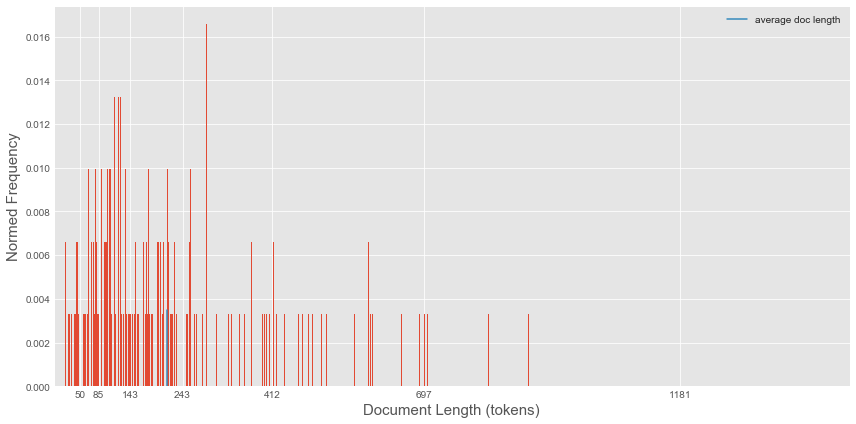

In [11]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,1500)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [12]:
# only keep articles with more than 5 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 5]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 344 articles


In [13]:
df.head()

,title,text,label,tokenized
0,This man claims to be Pakistan's answer to the...,This man claims to be Pakistan's answer to the...,Fake,"[man, claim, pakistan, answer, hulkmardan, wei..."
1,Grade 20 officer steals Kuwaiti delegate’s wal...,ISLAMABAD: The government was exposed to extre...,Fake,"[islamabad, govern, expos, extrem, embarrass, ..."
2,Paid day-to-day expenses of PM House from my o...,Incarcerated former prime minister Nawaz Shari...,Fake,"[incarcer, former, prime, minist, nawaz, shari..."
3,Rimal Khan and Her Alleged Relation With Imran...,"Rimal Ali, a female Transgender disowned by fa...",Fake,"[rimal, ali, femal, transgend, disown, famili,..."
4,Major oil find near Pak-Iran border,KARACHI: Minister for Maritime Affairs and For...,Fake,"[karachi, minist, maritim, affair, foreign, af..."


In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2)

from nltk.corpus import stopwords 
train.columns.values
train.head()

,title,text,label,tokenized
206,Fake news: Year-old screenshot of DawnNews sha...,A screenshot from a TV news report aired last ...,Fake,"[screenshot, tv, news, report, air, last, year..."
341,Fake news: Year-old screenshot of DawnNews sha...,A screenshot from a TV news report aired last ...,True,"[screenshot, tv, news, report, air, last, year..."
176,"Banks, cement help index close in green",KARACHI: Trading remained range-bound at the s...,True,"[karachi, trade, remain, rangebound, stock, ma..."
116,You can now travel from Karachi to Dhabeji in ...,\n\n\n\nDaily labourers will now be able to tr...,True,"[daili, labour, abl, travel, karachi, dhabeji,..."
254,Russia blocks Ukrainian navy from entering Sea...,KIEV: Ukraine’s navy said on Sunday that Russi...,True,"[kiev, ukrain, navi, said, sunday, russia, bor..."


In [15]:
import re
def refineWords(s):
    letters_only = re.sub("[^a-zA-Z]", " ", s) 
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    #print( " ".join( meaningful_words ))
    return( " ".join( meaningful_words ))

train["text"].fillna(" ",inplace=True)    
train["text"] = train["text"].apply(refineWords)
train["title"].fillna(" ",inplace=True)    
train["title"] = train["title"].apply(refineWords)

train_two = train.copy()
train.head()

C:\Users\iwx499921\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\iwx499921\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\iwx499921\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,title,text,label,tokenized
206,fake news year old screenshot dawnnews shared ...,screenshot tv news report aired last year dawn...,Fake,"[screenshot, tv, news, report, air, last, year..."
341,fake news year old screenshot dawnnews shared ...,screenshot tv news report aired last year dawn...,True,"[screenshot, tv, news, report, air, last, year..."
176,banks cement help index close green,karachi trading remained range bound stock mar...,True,"[karachi, trade, remain, rangebound, stock, ma..."
116,travel karachi dhabeji train,daily labourers able travel karachi dhabeji tr...,True,"[daili, labour, abl, travel, karachi, dhabeji,..."
254,russia blocks ukrainian navy entering sea azov,kiev ukraine navy said sunday russia border gu...,True,"[kiev, ukrain, navi, said, sunday, russia, bor..."


In [16]:
train = train_two.copy()
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
#print(train_one["title"].head())
#temp  = (vectorizer.fit_transform(train_one["text"]))
#train_one["text"] = temp.to_array()
train["text"] = vectorizer.fit_transform(train["text"]).toarray()
train["title"] = vectorizer.fit_transform(train["title"]).toarray()
train.head()

,title,text,label,tokenized
206,0,0,Fake,"[screenshot, tv, news, report, air, last, year..."
341,0,0,True,"[screenshot, tv, news, report, air, last, year..."
176,0,0,True,"[karachi, trade, remain, rangebound, stock, ma..."
116,0,0,True,"[daili, labour, abl, travel, karachi, dhabeji,..."
254,0,0,True,"[kiev, ukrain, navi, said, sunday, russia, bor..."


In [17]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth = 10, min_samples_split=2, n_estimators = 100, random_state = 1)
features_forest = train[["text", "title"]].values
my_forest = forest.fit(features_forest, train["label"])

C:\Users\iwx499921\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [18]:
target = train["label"].values
print(my_forest.score(features_forest, target))

0.5636363636363636


In [19]:
test["text"].fillna(" ",inplace=True)    
test["text"] = test["text"].apply(refineWords)
test["title"].fillna(" ",inplace=True)    
test["title"] = test["title"].apply(refineWords)

test_two = test.copy()

test["text"] = vectorizer.fit_transform(test["text"]).toarray()
test["title"] = vectorizer.fit_transform(test["title"]).toarray()

C:\Users\iwx499921\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\iwx499921\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\iwx499921\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [20]:
test_features = test[["text", "title"]].values
my_prediction = my_forest.predict(test_features)
print(len(my_prediction),len(test["label"]))


69 69


In [21]:
count = 0
pred = my_prediction.tolist()
test_spam = test["label"].tolist()
for i in range(len(pred)):
    if pred[i] == test_spam[i]:
        count += 1
print(count,float(count)/len(my_prediction))
#print(my_prediction)
#print(test_spam)

38 0.5507246376811594


In [22]:
print(my_prediction)



['Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake'
 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake'
 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake'
 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake'
 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake'
 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake'
 'True ' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake' 'Fake']


In [23]:
print(test_spam)

['Fake', 'True ', 'True ', 'True ', 'True ', 'Fake', 'Fake', 'True ', 'Fake', 'True ', 'True ', 'True ', 'Fake', 'Fake', 'True ', 'True ', 'True ', 'True ', 'Fake', 'True ', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'True ', 'True ', 'Fake', 'Fake', 'True ', 'Fake', 'True ', 'Fake', 'True ', 'Fake', 'Fake', 'True ', 'True ', 'True ', 'Fake', 'True ', 'Fake', 'Fake', 'Fake', 'True ', 'Fake', 'Fake', 'True ', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'True ', 'True ', 'Fake', 'True ', 'Fake', 'True ', 'Fake', 'True ', 'Fake', 'Fake', 'Fake', 'True ', 'True ', 'True ', 'Fake', 'Fake']
